In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [6]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

In [95]:
graph.nodes[0]

{'reaction': {'reaction_string': '2 CH2O2 = 1 O2 + 1 CH3COOH',
  'reactants': {'CH2O2': 2},
  'products': {'O2': 1, 'CH3COOH': 1}},
 'equilibrium_constant': np.float64(8.902848431025934e-08)}

In [109]:
testreaction = data[3]['reaction_statistics'][1]
testreaction

{'reaction': {'reaction_string': '2 O2 + 1 N2 = 2 NO2',
  'reactants': {'O2': 2, 'N2': 1},
  'products': {'NO2': 2}},
 'equilibrium_constant': np.float64(9.688799568704836e-05)}

In [111]:
def flip_reaction(reaction_data):
    k = reaction_data['equilibrium_constant']
    reaction_string = reaction_data['reaction']['reaction_string']
    reactants = reaction_data['reaction']['reactants']
    products = reaction_data['reaction']['products']
    if k >= 1:
        return(reaction_data)
    else:
        new_dict = {'reactants':products,'products':reactants}
        r,p = reaction_string.split('=')
        new_dict['reaction_string'] = f'{p} = {r}'
        return({'reaction':new_dict,'equilibrium_constant':1/k}) 

flip_reaction(testreaction)

{'reaction': {'reactants': {'NO2': 2},
  'products': {'O2': 2, 'N2': 1},
  'reaction_string': ' 2 NO2 = 2 O2 + 1 N2 '},
 'equilibrium_constant': np.float64(10321.19606674531)}

#### 2. Sample the `graph`

In [93]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':0,'NO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### 3. generate reaction statistics

In [96]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(20)

2 H2 + 1 O2 = 2 H2O                       459
1 H2 + 1 NO2 = 1 H2O + 1 NO               271
1 H2O + 1 SO2 = 1 H2SO3                   211
1 H2O + 1 SO2 + 1 NO2 = 1 H2SO4 + 1 NO    203
1 H2O + 1 NO2 + 1 NO = 2 HNO2             171
8 O2 + 1 S8 = 8 SO2                       110
1 S8 + 8 NO2 = 8 SO2 + 4 N2               106
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2            100
3 H2 + 1 SO2 = 2 H2O + 1 H2S               99
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2            76
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4             64
1 H2O + 3 NO2 = 2 HNO3 + 1 NO              64
2 O2 + 1 N2 = 2 NO2                        60
1 S8 + 16 NO2 = 8 SO2 + 16 NO              56
1 O2 + 2 NO = 2 NO2                        56
16 H2O + 3 S8 = 16 H2S + 8 SO2             55
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4              40
4 H2 + 2 NO2 = 4 H2O + 1 N2                39
1 H2 + 2 HNO3 = 2 H2O + 2 NO2              36
1 H2 + 1 H2SO4 = 1 H2O + 1 H2SO3           36
dtype: int64

#### 4. generate mean concentrations and differences

In [97]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

        initial   mean  diff   sem   std    var
H2O        30.0  25.30 -4.70  0.09  4.76  22.64
NO2        10.0   6.48 -3.52  0.08  4.55  20.73
SO2        10.0   6.53 -3.47  0.08  4.18  17.45
O2         10.0   9.92 -0.08  0.04  2.11   4.46
S8          0.0   0.00  0.00  0.00  0.00   0.00
NH3         0.0   0.01  0.01  0.00  0.14   0.02
H2S         0.0   0.02  0.02  0.00  0.23   0.05
NOHSO4      0.0   0.08  0.08  0.01  0.61   0.37
N2          0.0   0.16  0.16  0.02  0.85   0.72
H2          0.0   0.38  0.38  0.02  1.35   1.82
HNO2        0.0   0.70  0.70  0.03  1.88   3.53
H2SO3       0.0   0.99  0.99  0.04  2.44   5.93
HNO3        0.0   1.07  1.07  0.04  2.38   5.68
NO          0.0   1.36  1.36  0.06  3.12   9.75
H2SO4       0.0   2.38  2.38  0.07  3.88  15.09


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_32564/949321809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name='RdBu')  # or any other colormap


<Axes: >

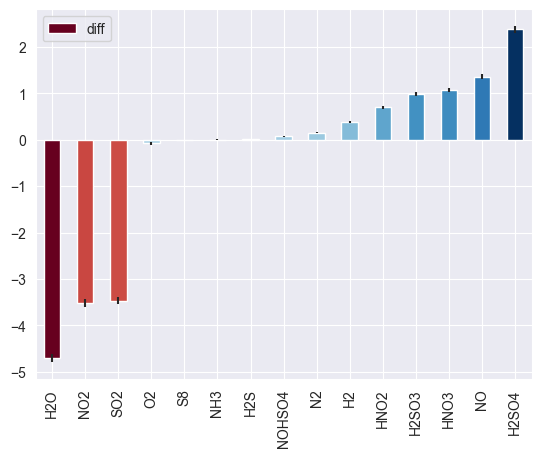

In [98]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [16]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white','directed':True}
g = analysis.result_to_pyvis(data,head=20,**pyvis_kwargs)
g.save_graph(name="example_pyvis_graph.html")

In [37]:
! open example_pyvis_graph.html